# TSF Lecture 4: Machine Learning Methods for Multivariate Time Series Forecasting
#
**Goals of This Lecture:**
#
In the previous lectures, you explored various time series analysis and forecasting techniques—from basic univariate forecasting methods to more complex multivariate approaches like VAR. In this lecture, you will apply several **machine learning** models to forecast a target variable (ENSO) using multiple regressors (AAO, AO, NAO, PNA, ENSO itself as a lagged predictor if desired).
#
Specifically, you will:
- **Section 1**: Introduce **Support Vector Regression (SVR)** for multivariate forecasting.
- **Section 2**: Repeat the process using **K-Nearest Neighbors** regression.
- **Section 3**: Use a **Decision Tree** regressor.
- **Section 4**: Use a **Random Forest** regressor.
- **Section 5**: Compare models in two ways:
  1. **Simple Out-of-Sample Forecast**: Fit the model once on the training set and forecast the entire test set.
  2. **Rolling Forecast**: Fit the model in a rolling (iterative) manner, forecasting one step at a time and then updating the training data.
#
You may find that each model comes with its own pros and cons. You will discuss them along the way.
#
As always, you will use a second-person narrative (“You may notice… You need to…”) to guide you through the learning process.


## SECTION 0: Imports and Helper Functions
#
You first need to import the necessary libraries and define helper functions such as error metrics and confidence-interval calculators.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import models and utilities
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For hyperparameter tuning later
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set()
plt.style.use('ggplot')

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def max_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

def mase(y_true, y_pred, y_train):
    numerator = np.mean(np.abs(y_true - y_pred))
    denominator = np.mean(np.abs(np.diff(y_train)))
    return numerator / denominator

def bootstrap_confidence_intervals(predictions, residuals, alpha=0.1):
    # A simple CI approximation using std of residuals and a z-score ~1.645 for ~90% CI
    if len(residuals) == 0:
        return predictions, predictions
    std_resid = np.std(residuals)
    z_value = 1.645
    lower = predictions - z_value * std_resid
    upper = predictions + z_value * std_resid
    return lower, upper


## SECTION 1: Support Vector Regression (SVR) for Multivariate Forecasting
#
In this section, you will:
1. **Load** the `combined_climate_indices_2024.csv` dataset (with columns `Date, AAO, AO, NAO, PNA, ENSO`).
2. **Visualize** the time series.
3. Prepare the data for **multivariate forecasting** of `ENSO`.
4. **Train/Test split**.
5. Fit various **SVR** models on the **training** set.
6. Produce an **out-of-sample** forecast for the **test** set.
7. **Visualize** the fitted values, forecasts, and **90% CI**.


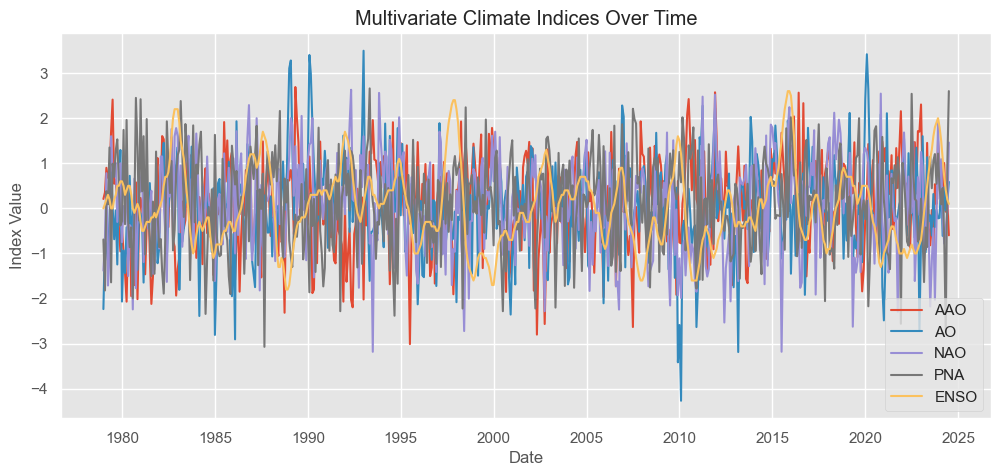

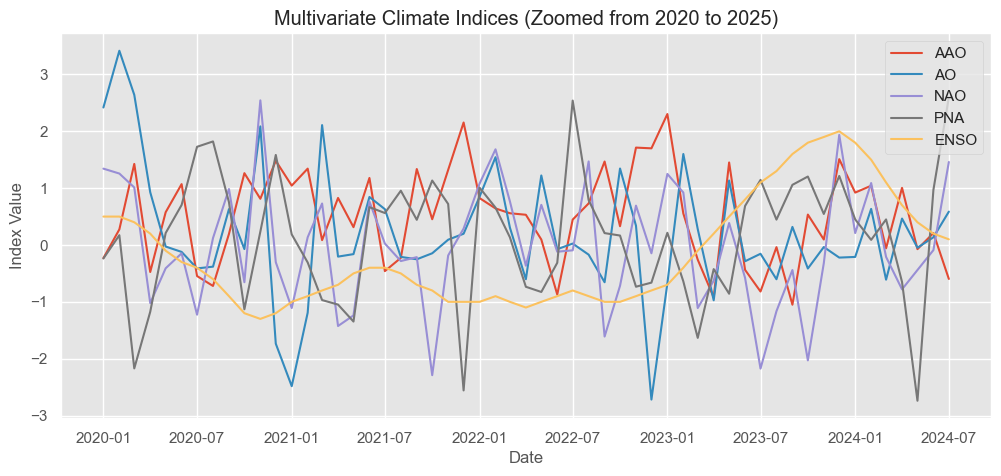

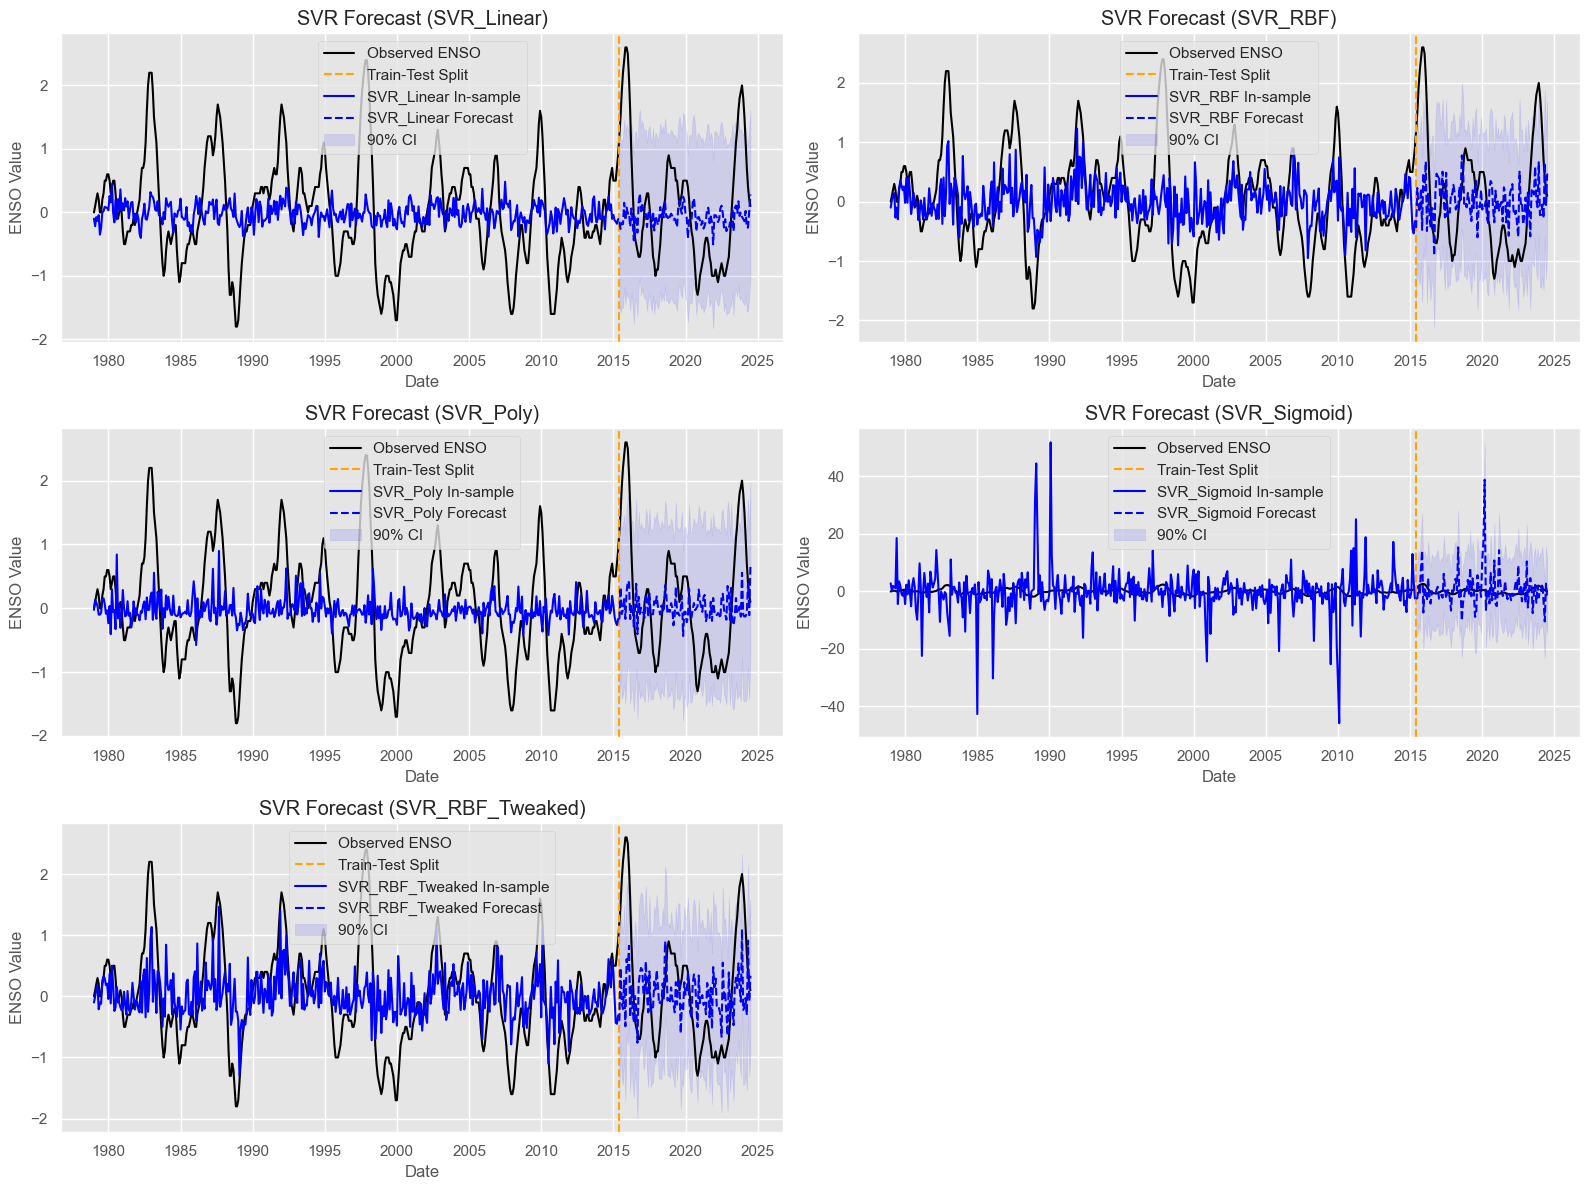

In [2]:
# --------------------------
# Step 1: Load and prepare data
# --------------------------
df = pd.read_csv('combined_climate_indices_2024.csv', parse_dates=['Date'], dayfirst=False)
df = df.set_index('Date').sort_index()
df = df.asfreq('MS')  # monthly start frequency
df.interpolate(method='linear', inplace=True)

# Define the regressors (X) and the target (y)
target_col = 'ENSO'
X = df.drop(columns=[target_col])  # All columns except ENSO
y = df[target_col]

# --------------------------
# Visualization of the full series
# --------------------------
plt.figure(figsize=(12, 5))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.title("Multivariate Climate Indices Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

# --------------------------
# 1B. Zoomed Plot (Approx. 2020 - 2025)
# --------------------------
zoom_start = '2020-01-01'
zoom_end = '2025-12-01'
df_zoom = df.loc[zoom_start:zoom_end]

plt.figure(figsize=(12, 5))
for col in df_zoom.columns:
    plt.plot(df_zoom.index, df_zoom[col], label=col)
plt.title("Multivariate Climate Indices (Zoomed from 2020 to 2025)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

# --------------------------
# Step 2: Train/test split
# --------------------------
train_ratio = 0.8
n = len(df)
split_index = int(n * train_ratio)

train_X = X.iloc[:split_index]
train_y = y.iloc[:split_index]
test_X = X.iloc[split_index:]
test_y = y.iloc[split_index:]

# --------------------------
# Step 3: Fit various SVR models (different kernels) on training data
# --------------------------
# We'll demonstrate several kernels: 'linear', 'rbf', 'poly', 'sigmoid', and a tweaked RBF.
svr_models = {
    'SVR_Linear': SVR(kernel='linear', C=1.0, epsilon=0.1),
    'SVR_RBF': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'SVR_Poly': SVR(kernel='poly', C=1.0, epsilon=0.1, degree=2),
    'SVR_Sigmoid': SVR(kernel='sigmoid', C=1.0, epsilon=0.1),
    'SVR_RBF_Tweaked': SVR(kernel='rbf', C=10.0, gamma=0.1, epsilon=0.1)
}

results_svr = {}

for model_name, svr_model in svr_models.items():
    svr_model.fit(train_X, train_y)
    # In-sample fitted values
    in_sample_fit = svr_model.predict(train_X)
    # Out-of-sample forecast
    out_sample_pred = svr_model.predict(test_X)

    results_svr[model_name] = {
        'model': svr_model,
        'in_sample_fit': in_sample_fit,
        'out_sample_pred': out_sample_pred
    }

# --------------------------
# Step 4: Visualize forecasts for each SVR model
# --------------------------
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()  # To index them easily in a loop

model_names = list(results_svr.keys())  # e.g. ['SVR_Linear', 'SVR_RBF', 'SVR_Poly', 'SVR_Sigmoid', 'SVR_RBF_Tweaked']

for i, model_name in enumerate(model_names):
    ax = axes[i]

    # Retrieve the in-sample fit and out-of-sample predictions
    in_sample_fit = results_svr[model_name]['in_sample_fit']
    out_sample_pred = results_svr[model_name]['out_sample_pred']

    # Calculate residuals on training set for CI computation
    train_residuals = train_y.values - in_sample_fit
    lower_ci, upper_ci = bootstrap_confidence_intervals(out_sample_pred, train_residuals)

    # Plot observed series
    ax.plot(y.index, y, label='Observed ENSO', color='black')
    # Train-test split line
    ax.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')
    # In-sample fit
    ax.plot(train_y.index, in_sample_fit, label=f'{model_name} In-sample', color='blue')
    # Out-of-sample forecast
    ax.plot(test_y.index, out_sample_pred, label=f'{model_name} Forecast', color='blue', linestyle='--')
    # Confidence bands
    ax.fill_between(test_y.index, lower_ci, upper_ci, color='blue', alpha=0.1, label='90% CI')

    ax.set_title(f"SVR Forecast ({model_name})")
    ax.set_xlabel("Date")
    ax.set_ylabel("ENSO Value")
    ax.legend()

# Hide any unused subplots
if len(axes) > len(model_names):
    for j in range(len(model_names), len(axes)):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Discussion of SVR Results:**
- The linear kernel may underfit non-linear relationships.
- The RBF kernel often captures non-linear relationships better, but tuning `C` and `gamma` is crucial.
- The polynomial kernel can capture non-linearity, but may become complex if the degree is high.
- Compare residuals and forecast accuracy to decide which kernel performs best.
#
## SECTION 2: K-Nearest Neighbors Regression
#
**Why KNN?**
- KNN regression predicts a new data point’s value by averaging the values of its K nearest neighbors.
- It is simple and non-parametric, but sensitive to feature scaling and the choice of K.


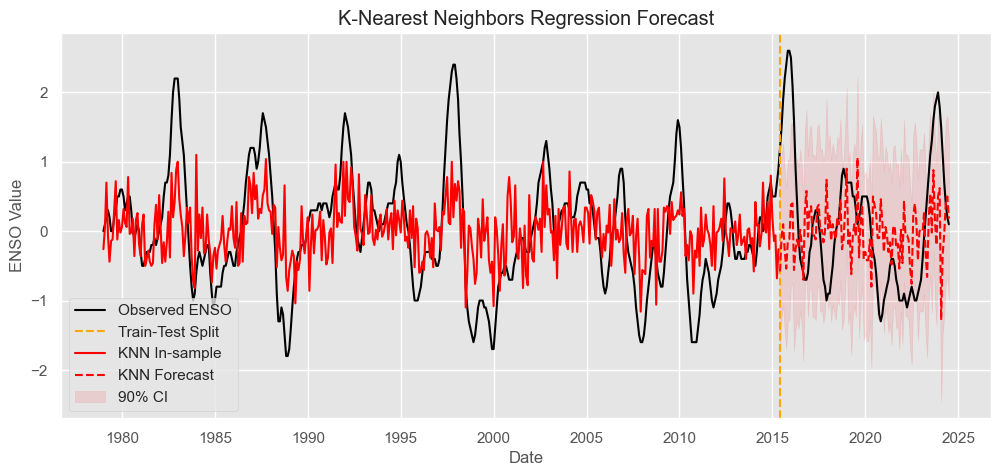

In [3]:
# Import KNeighborsRegressor is already done above.
knn_model = KNeighborsRegressor(n_neighbors=5, metric='euclidean')  # You may vary n_neighbors
# LINK TO LIST OF METRICS: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics

# ‘euclidean’
# ‘cityblock’
# ‘manhattan’
# --- Einstein's Metric: Lorentzian

knn_model.fit(train_X, train_y)

knn_in_sample_fit = knn_model.predict(train_X)
knn_out_sample_pred = knn_model.predict(test_X)

# Residuals for confidence intervals from the training set
knn_residuals = train_y.values - knn_in_sample_fit
knn_lower_ci, knn_upper_ci = bootstrap_confidence_intervals(knn_out_sample_pred, knn_residuals)

# Visualization for KNN
plt.figure(figsize=(12, 5))
plt.plot(y.index, y, label='Observed ENSO', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(train_y.index, knn_in_sample_fit, label='KNN In-sample', color='red')
plt.plot(test_y.index, knn_out_sample_pred, label='KNN Forecast', color='red', linestyle='--')
plt.fill_between(test_y.index, knn_lower_ci, knn_upper_ci, color='red', alpha=0.1, label='90% CI')
plt.title("K-Nearest Neighbors Regression Forecast")
plt.xlabel("Date")
plt.ylabel("ENSO Value")
plt.legend()
plt.show()


**Discussion of KNN:**
- The forecast can appear choppy due to its local averaging nature.
- A too-small K may yield noisy predictions while a too-large K may over-smooth.
- Scaling is important since KNN uses distance metrics.


## SECTION 3: Decision Tree Regression
#
**Why Decision Trees?**
- Decision Trees partition the feature space into regions based on conditions.
- They are interpretable and can handle non-linear relationships, but may overfit if not tuned.
#
**Process:**
1. Use the same train/test split.
2. Fit a Decision Tree (with minimal tuning).
3. Plot in-sample, out-of-sample predictions, and 90% CI.


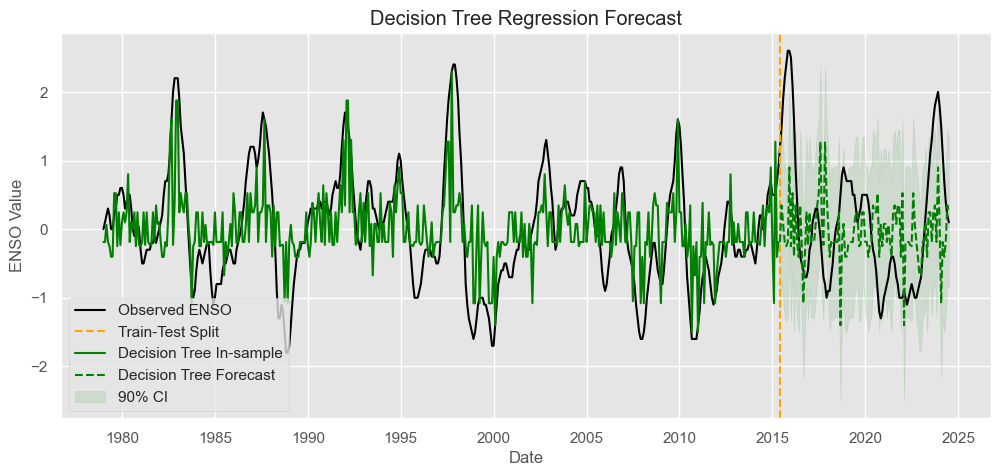

In [4]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(train_X, train_y)

tree_in_sample_fit = tree_model.predict(train_X)
tree_out_sample_pred = tree_model.predict(test_X)

tree_residuals = train_y.values - tree_in_sample_fit
tree_lower_ci, tree_upper_ci = bootstrap_confidence_intervals(tree_out_sample_pred, tree_residuals)

plt.figure(figsize=(12, 5))
plt.plot(y.index, y, label='Observed ENSO', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(train_y.index, tree_in_sample_fit, label='Decision Tree In-sample', color='green')
plt.plot(test_y.index, tree_out_sample_pred, label='Decision Tree Forecast', color='green', linestyle='--')
plt.fill_between(test_y.index, tree_lower_ci, tree_upper_ci, color='green', alpha=0.1, label='90% CI')
plt.title("Decision Tree Regression Forecast")
plt.xlabel("Date")
plt.ylabel("ENSO Value")
plt.legend()
plt.show()


**Discussion of Decision Trees:**
- A shallow tree might underfit while a deep tree could overfit.
- They model interactions well but can be unstable if not tuned or pruned.


## SECTION 4: Random Forest Regression
#
**Why Random Forest?**
- Random Forest ensembles multiple Decision Trees, often reducing variance and improving stability.
- It handles non-linearities and interactions, but is less interpretable.
#
**Process:**
1. Use the same train/test split.
2. Fit a Random Forest on the training set.
3. Visualize the predictions and 90% CI.


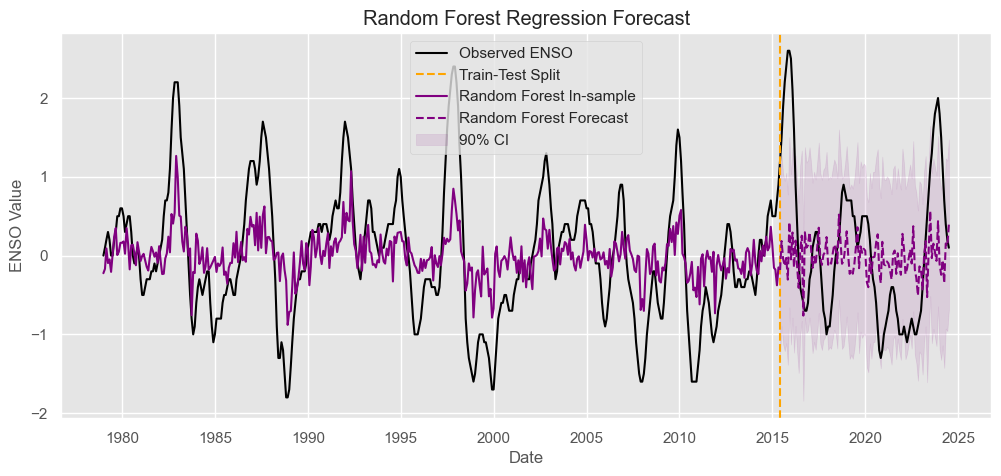

In [5]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(train_X, train_y)

rf_in_sample_fit = rf_model.predict(train_X)
rf_out_sample_pred = rf_model.predict(test_X)

rf_residuals = train_y.values - rf_in_sample_fit
rf_lower_ci, rf_upper_ci = bootstrap_confidence_intervals(rf_out_sample_pred, rf_residuals)

plt.figure(figsize=(12, 5))
plt.plot(y.index, y, label='Observed ENSO', color='black')
plt.axvline(x=y.index[split_index], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(train_y.index, rf_in_sample_fit, label='Random Forest In-sample', color='purple')
plt.plot(test_y.index, rf_out_sample_pred, label='Random Forest Forecast', color='purple', linestyle='--')
plt.fill_between(test_y.index, rf_lower_ci, rf_upper_ci, color='purple', alpha=0.1, label='90% CI')
plt.title("Random Forest Regression Forecast")
plt.xlabel("Date")
plt.ylabel("ENSO Value")
plt.legend()
plt.show()


**Discussion of Random Forest:**
- Ensemble methods often reduce variance compared to single trees.
- Tuning parameters like `n_estimators`, `max_depth`, and `min_samples_split` is key.


## SECTION 5: Accuracy Comparison for Simple vs. Rolling Forecasts
#
You now have four ML models:
1. **SVR** (we'll use the RBF variant here)
2. **KNN**
3. **Decision Tree**
4. **Random Forest**
#
We will compute accuracy metrics for both a simple out-of-sample forecast and a rolling forecast.


In [6]:
# Use predictions from one chosen forecast per model
svr_rbf_out = results_svr['SVR_RBF']['out_sample_pred']
knn_out = knn_out_sample_pred
tree_out = tree_out_sample_pred
rf_out = rf_out_sample_pred

test_actual = test_y.values  # True values in test set
train_actual = train_y.values

def compute_metrics(y_true, y_pred, y_train):
    return {
        'max_error': max_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'MASE': mase(y_true, y_pred, y_train)
    }

models_simple = {
    'SVR_RBF': svr_rbf_out,
    'KNN': knn_out,
    'DecisionTree': tree_out,
    'RandomForest': rf_out
}

simple_results = {}
for m_name, preds in models_simple.items():
    simple_results[m_name] = compute_metrics(test_actual, preds, train_actual)

df_simple_results = pd.DataFrame(simple_results).T
print("Simple Out-of-Sample Forecasting Accuracy (Metrics):")
print(df_simple_results)


Simple Out-of-Sample Forecasting Accuracy (Metrics):
              max_error       MAE       MSE      RMSE          MAPE      MASE
SVR_RBF        3.075105  0.810308  0.999582  0.999791  2.303993e+07  5.296764
KNN            2.940000  0.845636  1.134978  1.065354  1.090922e+07  5.527698
DecisionTree   2.786777  0.844507  1.118159  1.057431  1.697984e+07  5.520318
RandomForest   2.904650  0.796798  0.980040  0.989970  7.258650e+06  5.208452


### 5.2 Rolling Forecast
#
**Rolling Forecast Steps:**
1. Start with the training set.
2. Fit the model and predict the next time step from the test set.
3. Append the actual observation from the test set to the training data (“roll” forward).
4. Repeat until forecasts for the entire test set are obtained.
#
This is more computationally expensive but more realistic.


In [7]:
def rolling_forecast(model_constructor, train_X, train_y, test_X, test_y):
    """
    Generic rolling forecast function:
      - model_constructor: a function that returns a fresh model instance
      - train_X, train_y: initial training data
      - test_X, test_y: the entire test set
    Forecast one step ahead iteratively.
    """
    history_X = train_X.copy()
    history_y = train_y.copy()
    preds = []

    for i in range(len(test_X)):
        # Instantiate and fit a new model
        model = model_constructor()
        model.fit(history_X, history_y)

        # Predict the next step
        x_next = test_X.iloc[i:i + 1]  # single step
        pred_next = model.predict(x_next)[0]
        preds.append(pred_next)

        # "Roll" forward: add the actual observation to the history
        y_next = test_y.iloc[i]
        history_X = pd.concat([history_X, x_next])
        history_y = pd.concat([history_y, pd.Series([y_next], index=[test_y.index[i]])])

    return np.array(preds)

# Define constructors for each model for rolling forecasts

def svr_rbf_constructor():
    return SVR(kernel='rbf', C=1.0, epsilon=0.1)

def knn_constructor():
    return KNeighborsRegressor(n_neighbors=5)

def tree_constructor():
    return DecisionTreeRegressor(max_depth=5, random_state=42)

def rf_constructor():
    return RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Perform rolling forecasts
svr_rbf_rolling = rolling_forecast(svr_rbf_constructor, train_X, train_y, test_X, test_y)
knn_rolling = rolling_forecast(knn_constructor, train_X, train_y, test_X, test_y)
tree_rolling = rolling_forecast(tree_constructor, train_X, train_y, test_X, test_y)
rf_rolling = rolling_forecast(rf_constructor, train_X, train_y, test_X, test_y)

models_rolling = {
    'SVR_RBF': svr_rbf_rolling,
    'KNN': knn_rolling,
    'DecisionTree': tree_rolling,
    'RandomForest': rf_rolling
}

rolling_results = {}
for m_name, preds in models_rolling.items():
    rolling_results[m_name] = compute_metrics(test_actual, preds, train_actual)

df_rolling_results = pd.DataFrame(rolling_results).T
print("\nRolling Forecasting Accuracy (Metrics):")
print(df_rolling_results)



Rolling Forecasting Accuracy (Metrics):
              max_error       MAE       MSE      RMSE          MAPE      MASE
SVR_RBF        3.074423  0.808522  1.009383  1.004681  1.686840e+07  5.285092
KNN            2.940000  0.861636  1.186738  1.089375  9.091037e+06  5.632286
DecisionTree   3.633333  0.890693  1.228222  1.108252  5.124103e+06  5.822218
RandomForest   2.798464  0.803144  1.009655  1.004816  1.974407e+06  5.249937


**Interpretation:**
- Compare the metrics from the simple forecast and the rolling forecast.
- Rolling forecasts often yield different (sometimes more conservative) error values since the model is retrained at every step.
#
## SECTION 6: Hyperparameter Optimization for SVR, KNN, Decision Tree, and Random Forest
#
Now we perform a small grid search to tune key hyperparameters for each model.
We use 3-fold cross-validation and a reduced grid to avoid huge computation times.


In [9]:
print("\nHyperparameter Optimization Results\n")

# --- Helper function for metrics (if not already defined) ---
def compute_metrics(y_true, y_pred, y_train):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    metrics = {
        'max_error': np.max(np.abs(y_true - y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'MASE': np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(np.diff(y_train)))
    }
    return metrics

# ---------- SVR Hyperparameter Tuning ----------
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
param_grid_svr = {
    'svr__C': [0.1, 1.0, 10.0],
    'svr__epsilon': [0.01, 0.1],
    'svr__gamma': ['scale', 0.1],
    'svr__kernel': ['rbf', 'sigmoid', 'poly']
}
grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=3,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(train_X, train_y)
best_svr = grid_search_svr.best_estimator_
print("Best SVR Parameters:", grid_search_svr.best_params_)
svr_pred = best_svr.predict(test_X)
svr_metrics = compute_metrics(test_y.values, svr_pred, train_y.values)

# ---------- KNN Hyperparameter Tuning ----------
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7]
}
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=3,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(train_X, train_y)
best_knn = grid_search_knn.best_estimator_
print("\nBest KNN Parameters:", grid_search_knn.best_params_)
knn_pred = best_knn.predict(test_X)
knn_metrics = compute_metrics(test_y.values, knn_pred, train_y.values)

# ---------- Decision Tree Hyperparameter Tuning ----------
param_grid_tree = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(random_state=42),
                                param_grid_tree, cv=3,
                                scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_tree.fit(train_X, train_y)
best_tree = grid_search_tree.best_estimator_
print("\nBest Decision Tree Parameters:", grid_search_tree.best_params_)
tree_pred = best_tree.predict(test_X)
tree_metrics = compute_metrics(test_y.values, tree_pred, train_y.values)

# ---------- Random Forest Hyperparameter Tuning ----------
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid_rf, cv=3,
                              scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(train_X, train_y)
best_rf = grid_search_rf.best_estimator_
print("\nBest Random Forest Parameters:", grid_search_rf.best_params_)
rf_pred = best_rf.predict(test_X)
rf_metrics = compute_metrics(test_y.values, rf_pred, train_y.values)

# ---------- Compile Metrics into a Table ----------
results_hp = {
    'SVR_RBF': svr_metrics,
    'KNN': knn_metrics,
    'DecisionTree': tree_metrics,
    'RandomForest': rf_metrics
}

df_results = pd.DataFrame(results_hp).T
# Optionally, reorder the columns:
df_results = df_results[['max_error', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE']]
print("\nSimple Out-of-Sample Forecasting Accuracy (Metrics):")
print(df_results)



Hyperparameter Optimization Results

Best SVR Parameters: {'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}

Best KNN Parameters: {'knn__n_neighbors': 7}

Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_split': 2}

Best Random Forest Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}

Simple Out-of-Sample Forecasting Accuracy (Metrics):
              max_error       MAE       MSE      RMSE          MAPE      MASE
SVR_RBF        2.639007  0.790376  0.960332  0.979965  8.845287e+06  5.166476
KNN            2.842857  0.818831  1.076369  1.037482  6.493623e+06  5.352480
DecisionTree   2.714925  0.795387  1.016191  1.008063  1.044787e+07  5.199233
RandomForest   2.829697  0.789207  0.980937  0.990423  6.766145e+06  5.158836
